## Investigating different cost functions

In this notebook, we take a look at the different fitting cost functions offered in PyBOP. Cost functions for fitting problems conventionally describe the distance between two points (the target and the prediction) which is to be minimised via PyBOP's optimisation algorithms. 

First, we install and import the required packages below.

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "svg"
import pybop

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


For this notebook, we need to construct parameters, a model and a problem class before we can compare differing cost functions. We start with two parameters, but this is an arbitrary selection and can be expanded given the model and data in question.

In [2]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "Positive electrode thickness [m]",
        prior=pybop.Gaussian(7.56e-05, 0.5e-05),
        bounds=[65e-06, 10e-05],
    ),
    pybop.Parameter(
        "Positive particle radius [m]",
        prior=pybop.Gaussian(5.22e-06, 0.5e-06),
        bounds=[2e-06, 9e-06],
    ),
)

Next, we will construct the Single Particle Model (SPM) with the Chen2020 parameter set, but like the above, this is an arbitrary selection and can be replaced with any PyBOP model.

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)

Next, as we will need reference data to compare our model predictions to (via the cost function), we will create synthetic data from the model constructed above. 

In [4]:
t_eval = np.arange(0, 900, 2)
values = model.predict(t_eval=t_eval)

We can then construct the PyBOP dataset class with the synthetic data as,

In [5]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": values["Voltage [V]"].data,
    }
)

Now, we can put this all together and construct the problem class. In this situation, we are going to compare differing fitting cost functions, so we construct the `FittingProblem`.

In [6]:
problem = pybop.FittingProblem(model, parameters, dataset)

### Sum of Squared Errors and Root Mean Squared Error

First, let's start with two commonly-used cost functions: the sum of squared errors (SSE) and the root mean squared error (RMSE). Constructing these classes is very concise in PyBOP, and only requires the problem class.

In [7]:
cost_SSE = pybop.SumSquaredError(problem)
cost_RMSE = pybop.RootMeanSquaredError(problem)

Now, we can investigate how these functions differ when fitting the parameters. To acquire the cost value for each of these, we can simply use the call method of the constructed class, such as:

In [8]:
cost_SSE([7.56e-05, 5.22e-06])

1.2690291451182834e-09

Alternatively, we can use the `Parameters` class for this,

In [9]:
print(parameters.current_value())
cost_SSE(parameters.current_value())

[7.56e-05 5.22e-06]


1.2690291451182834e-09

If we want to generate a random sample of candidate solutions from the parameter class prior, we can also do that as:

In [10]:
sample = parameters.rvs()
print(sample)
cost_SSE(sample)

[7.60957550e-05 5.48691392e-06]


0.014466013735507651

#### Comparing RMSE and SSE

Now, let's vary one of the parameters, and keep a fixed value for the other, to create a scatter plot comparing the cost values for the RMSE and SSE functions.

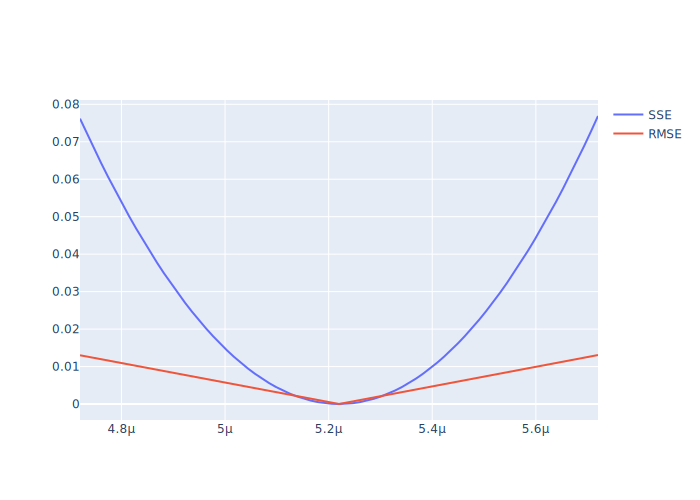

In [11]:
x_range = np.linspace(4.72e-06, 5.72e-06, 75)
y_SSE = []
y_RMSE = []
for i in x_range:
    y_SSE.append(cost_SSE([7.56e-05, i]))
    y_RMSE.append(cost_RMSE([7.56e-05, i]))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_range, y=y_SSE, mode="lines", name="SSE"))
fig.add_trace(go.Scatter(x=x_range, y=y_RMSE, mode="lines", name="RMSE"))
fig.show()

In this situation, it's clear that the curvature of the SSE cost is greater than that of the RMSE. This can improve the rate of convergence for certain optimisation algorithms. However, with incorrect hyperparameter values, larger gradients can also result in the algorithm not converging due to sampling locations outside of the "cost valley", e.g. infeasible parameter values.

### Minkowski distance

Next, let's investigate the Minkowski distance. The Minkowski cost takes a general form, which allows for hyperparameter calibration on the cost function itself, given by

$\mathcal{L_p} = \displaystyle \Big(\sum_i  |\hat{y_i}-y_i|^p\Big)^{1/p}$

where $p ≥ 0$ is the order of the Minkowski distance.

For $p = 1$, it is the Manhattan distance.  
For $p = 2$, it is the Euclidean distance.  
For $p ≥ 1$, the Minkowski distance is a metric, but for $0<p<1$, note that the Minkowski distance is not a metric because the triangle inequality does not hold [[1]](https://en.wikipedia.org/wiki/Minkowski_distance), [[2]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.minkowski.html#scipy.spatial.distance.minkowski).

The Minkowski distance is related to the previous two cost function as follows. The RMSE can be computed by dividing the Euclidean distance by the square root of the length of the target vector, while the SSE is the square of the Euclidean distance.

PyBOP offers a Minkowski class, which we will construct below. This class has an optional argument of `p` which designates the order in the above equation. This value can be a float, with the only requirement that it is not negative. First, let's confirm the relationship between the SSE, RMSE and the Minkowski distance with a `p` value of 2.

In [12]:
cost_minkowski = pybop.Minkowski(problem, p=2)

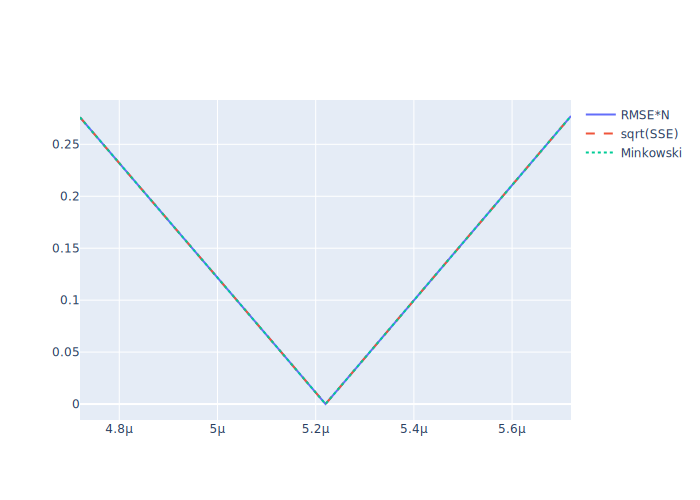

In [13]:
y_minkowski = []
for i in x_range:
    y_minkowski.append(cost_minkowski([7.56e-05, i]))

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=np.asarray(y_RMSE) * np.sqrt(len(t_eval)),
        mode="lines",
        name="RMSE*N",
    )
)
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=np.sqrt(y_SSE),
        mode="lines",
        line=dict(dash="dash"),
        name="sqrt(SSE)",
    )
)
fig.add_trace(
    go.Scatter(
        x=x_range, y=y_minkowski, mode="lines", line=dict(dash="dot"), name="Minkowski"
    )
)
fig.show()

As expected, these lines lie on top of one another. Now, let's take a look at how the Minkowski cost changes for different orders, `p`.

In [14]:
p_orders = np.append(0.75, np.linspace(1, 3, 5))
y_minkowski = tuple(
    [pybop.Minkowski(problem, p=j)([7.56e-05, i]) for i in x_range] for j in p_orders
)

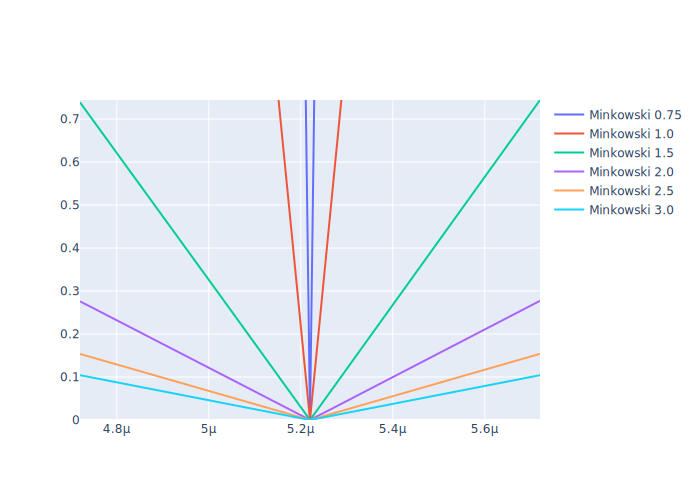

In [15]:
fig = go.Figure()
for k, _ in enumerate(p_orders):
    fig.add_trace(
        go.Scatter(x=x_range, y=y_minkowski[k], mode="lines", name=f"Minkowski {_}")
    )
fig.update_yaxes(range=[0, np.max(y_minkowski[2])])
fig.show()

As seen above, the Minkowski cost allows for a range of different cost functions to be created. This provides users with another hyperparameter to calibrate for optimisation algorithm convergence. This addition does expand the global search space, and should be carefully considered before deciding upon.

### Sum of Power
Next, we introduce a similar cost function, the `SumofPower` implementation. This cost function is the $p$-th power of the Minkowski distance of order $p$. It provides a generalised formulation for the Sum of Squared Errors (SSE) cost function, and is given by,

$\mathcal{L_p} = \displaystyle \sum_i  |\hat{y_i}-y_i|^p$

where $p ≥ 0$ is the power order. A few special cases include,

$p = 1$: Sum of Absolute Differences
$p = 2$: Sum of Squared Differences

Next we repeat the above examples with the addition of the `SumofPower` class.

In [16]:
cost_sumofpower = pybop.SumofPower(problem, p=2)

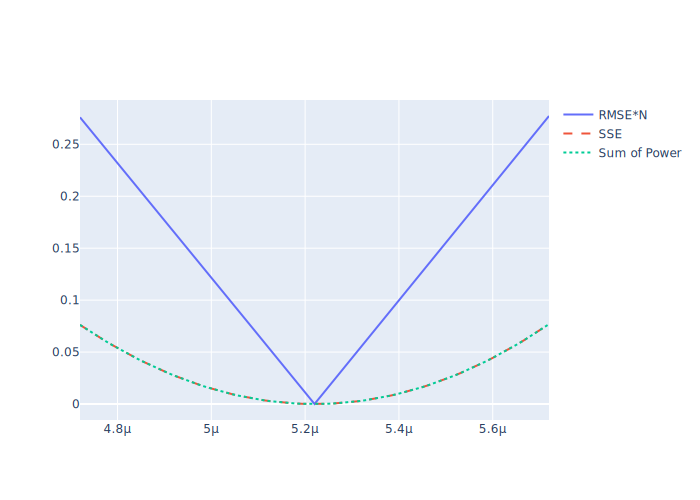

In [17]:
y_sumofpower = []
for i in x_range:
    y_sumofpower.append(cost_sumofpower([7.56e-05, i]))

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=np.asarray(y_RMSE) * np.sqrt(len(t_eval)),
        mode="lines",
        name="RMSE*N",
    )
)
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=y_SSE,
        mode="lines",
        line=dict(dash="dash"),
        name="SSE",
    )
)
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=y_sumofpower,
        mode="lines",
        line=dict(dash="dot"),
        name="Sum of Power",
    )
)
fig.show()

As expected, the `SumofPower` with order `p=2` equates to the `SSE` implementation. Next, we compare the `Minkowski` to the `SumofPower`,

In [18]:
p_orders = np.append(0.75, np.linspace(1, 2, 2))

y_minkowski = tuple(
    [pybop.Minkowski(problem, p=j)([7.56e-05, i]) for i in x_range] for j in p_orders
)

y_sumofpower = tuple(
    [pybop.SumofPower(problem, p=j)([7.56e-05, i]) for i in x_range] for j in p_orders
)

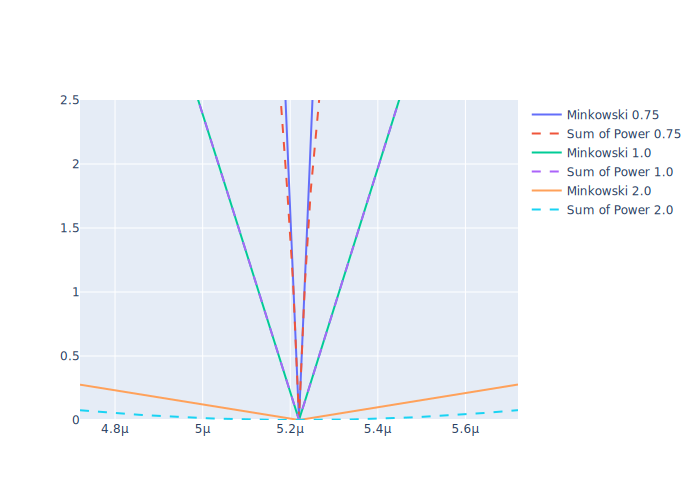

In [19]:
fig = go.Figure()
for k, _ in enumerate(p_orders):
    fig.add_trace(
        go.Scatter(x=x_range, y=y_minkowski[k], mode="lines", name=f"Minkowski {_}")
    )
    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_sumofpower[k],
            mode="lines",
            line=dict(dash="dash"),
            name=f"Sum of Power {_}",
        )
    )
fig.update_yaxes(range=[0, 2.5])
fig.show()

The figure demonstrates the distinct behaviour of the `Minkowski` distance and the `SumofPower` function. One notable difference is the effect of the `1/p` exponent in the `Minkowski` distance, which has a linearising impact on the response. This linearisation can enhance the robustness of certain optimisation algorithms, potentially making them less sensitive to outliers or extreme values. However, this increased robustness may come at the cost of a slower convergence rate, as the linearised response might require more iterations to reach the optimal solution. In contrast, the `SumofPower` function does not exhibit this linearising effect, which can lead to faster convergence in some cases but may be more susceptible to the influence of outliers or extreme values.

In this notebook, we've shown the different fitting cost functions offered in PyBOP. Selection between these functions can affect the optimisation result in the case that the optimiser hyperparameter values are not properly calibrated. 